# Data Exploration

In [1]:
import os #For file paths
import keras_cv #For audio spectrograms and data augmentation. This has some prebuilt models
import keras#Main deep learning framework you’re using to build models, layers, and training loops
import keras.backend as K #“Low-level” backend ops used inside/around Keras models
import tensorflow as tf #TensorFlow is one of the possible “backends” Keras can run on,
import tensorflow_io as tfio #For audio tasks,

import numpy as np 
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa #Core audio processing library in Python.
import IPython.display as ipd #For Jupyter/Colab display utilities.
import librosa.display as lid #Plotting helpers for audio from librosa.

import matplotlib.pyplot as plt
import matplotlib as mpl

import random
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
os.environ["KERAS_BACKEND"] = "torch"  # "jax" or "tensorflow" or "torch" 

2025-12-15 20:07:45.416140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765829265.644001      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765829265.714770      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

In [2]:
train_meta = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
eBird_Taxonomy = pd.read_csv('/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv')

In [3]:
#Configuration class to avoid having configuration features accidentally modified
class CFG:
    seed = 42
    
    # Input image size and batch size
    mels = 128
    img_size = [128, 512]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 10 
    sample_rate = 32000 #32 kHz were the downsampled dimensions
    audio_len = duration * sample_rate #douration * sample rate (samples per second)
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24, these are actually bird species (common names)
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {specs:idx for idx,specs in label2name.items()}

CFG = CFG()

In [4]:
BASE_PATH = '/kaggle/input/birdclef-2024'
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename #Get filepath for the each record
df['target'] = df.primary_label.map(CFG.name2label) #number for each species
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC164848
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,XC175797.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC175797
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,XC207738.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC207738
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,XC209218.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...,0,XC209218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24454,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/845747,XC845747.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC845747
24455,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/845817,XC845817.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC845817
24456,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856176,XC856176.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC856176
24457,zitcis1,[],[''],41.5607,-8.4236,Cisticola juncidis,Zitting Cisticola,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856723,XC856723.ogg,/kaggle/input/birdclef-2024/train_audio/zitcis...,181,XC856723


In [5]:
#Dictionary of species:
labels = df['primary_label'].unique()
species = df['common_name'].unique()
label2species = dict(zip(labels, species))

In [6]:
# Get the value counts of 'col_a'
counts = df['filename'].value_counts()

# Filter for elements with a count greater than 1
elements_with_count_gt_1 = counts[counts > 1].index.tolist()

print(elements_with_count_gt_1)

['XC503389.ogg', 'XC306398.ogg', 'XC514027.ogg', 'XC447036.ogg', 'XC522123.ogg', 'XC403621.ogg', 'XC574864.ogg', 'XC184466.ogg', 'XC659329.ogg', 'XC467373.ogg', 'XC209564.ogg', 'XC581045.ogg', 'XC239509.ogg', 'XC209549.ogg', 'XC163901.ogg', 'XC674522.ogg', 'XC208795.ogg', 'XC208794.ogg', 'XC209203.ogg']


In [7]:
df['primary_label'].value_counts() , CFG.num_classes

(primary_label
 zitcis1    500
 lirplo     500
 litgre1    500
 comgre     500
 comkin1    500
           ... 
 blaeag1      6
 wynlau1      6
 niwpig1      5
 asiope1      5
 integr       5
 Name: count, Length: 182, dtype: int64,
 182)

In [8]:
set(df['primary_label'].value_counts().values)

{5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 49,
 51,
 52,
 53,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 67,
 70,
 71,
 75,
 76,
 77,
 79,
 86,
 89,
 90,
 92,
 96,
 101,
 102,
 104,
 105,
 107,
 109,
 113,
 114,
 115,
 122,
 123,
 124,
 125,
 127,
 135,
 137,
 139,
 141,
 142,
 150,
 153,
 155,
 163,
 167,
 173,
 185,
 189,
 198,
 201,
 210,
 217,
 219,
 224,
 226,
 231,
 235,
 237,
 268,
 271,
 273,
 274,
 275,
 276,
 278,
 302,
 405,
 420,
 500}

In [9]:
label2species['pursun4']

'Purple Sunbird'

<BarContainer object of 182 artists>

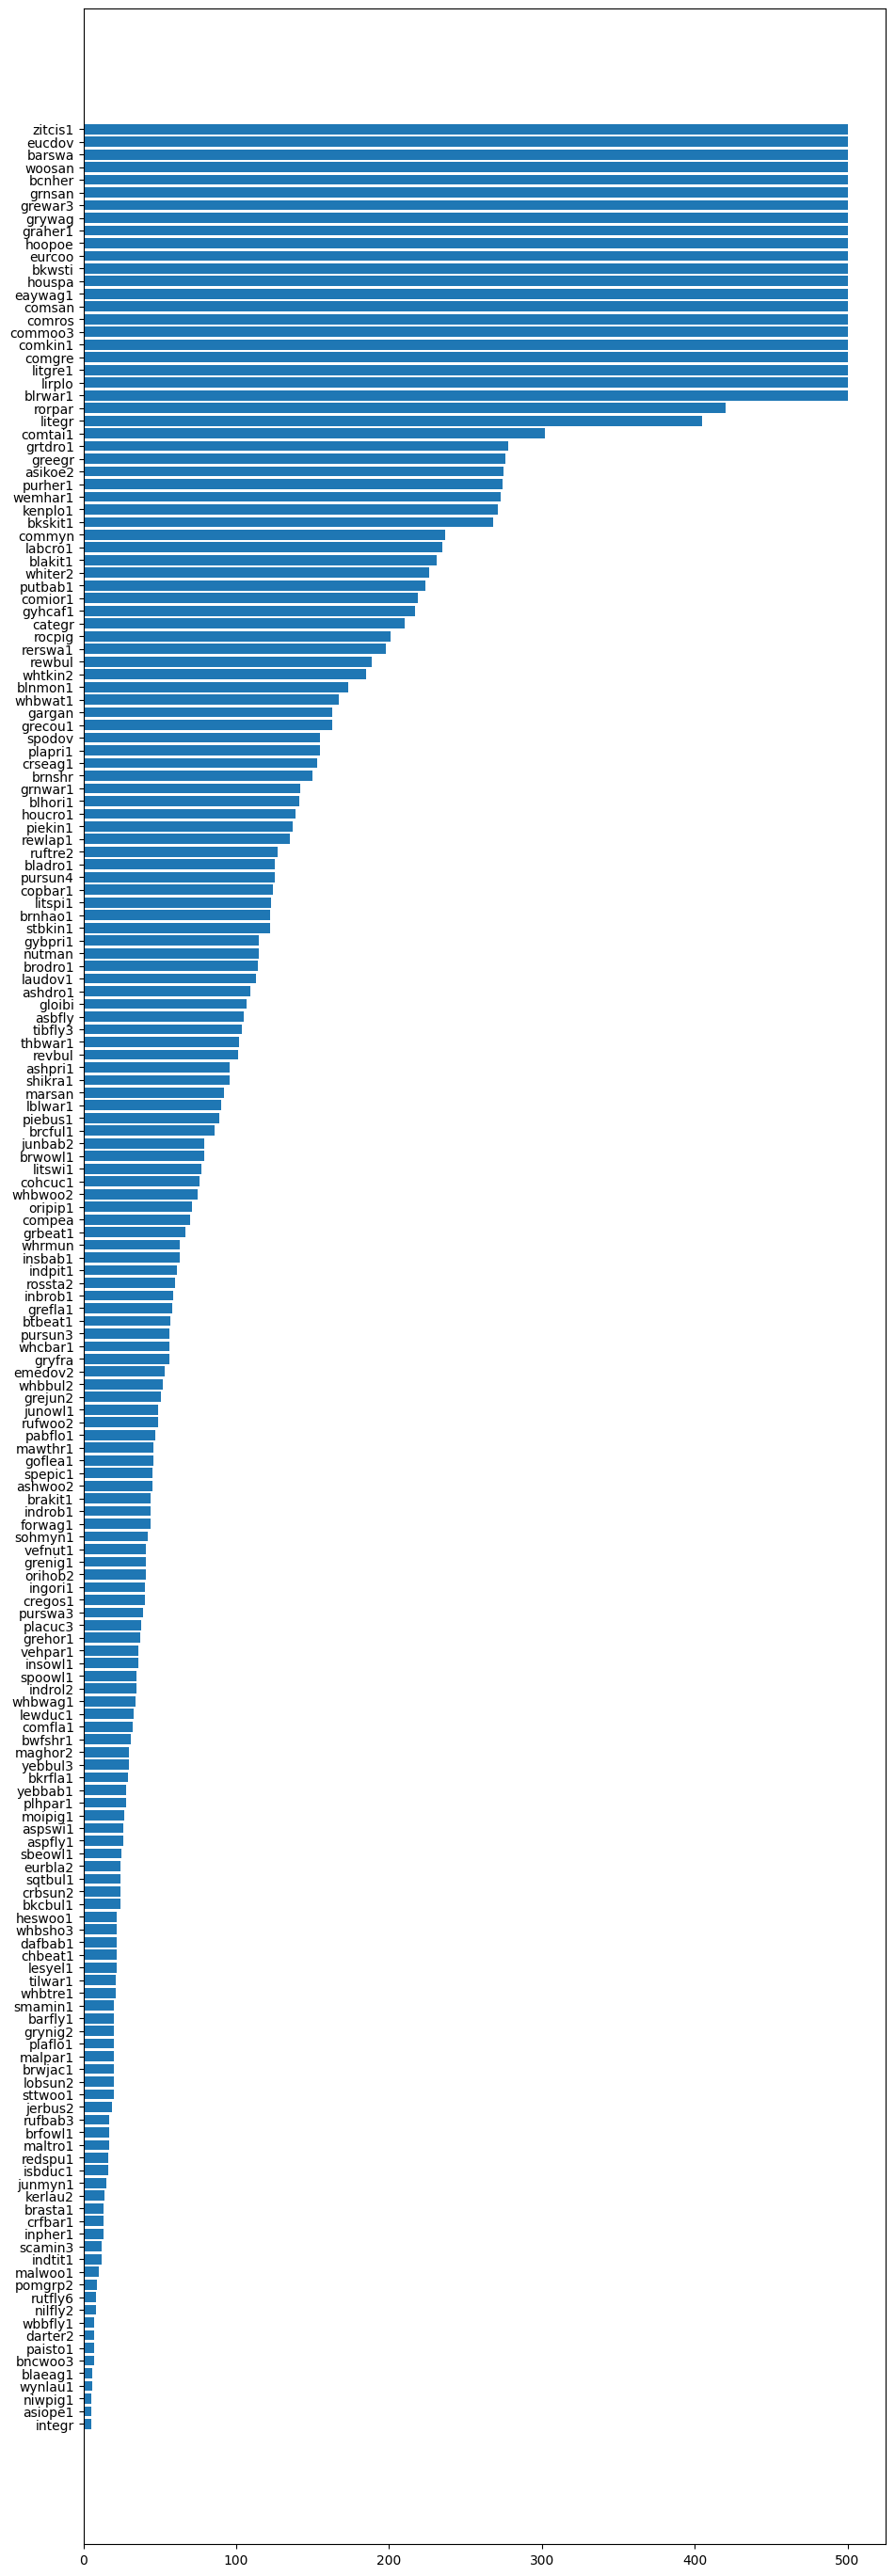

In [10]:
sample_count_by_species = df['primary_label'].value_counts().sort_values()#.plot(kind = 'barh', )
plt.figure(figsize=(11, 35)) 
plt.barh(sample_count_by_species.index, sample_count_by_species.values)

# Audio Transformation

In [11]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    #Input: dataframe row
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0])
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


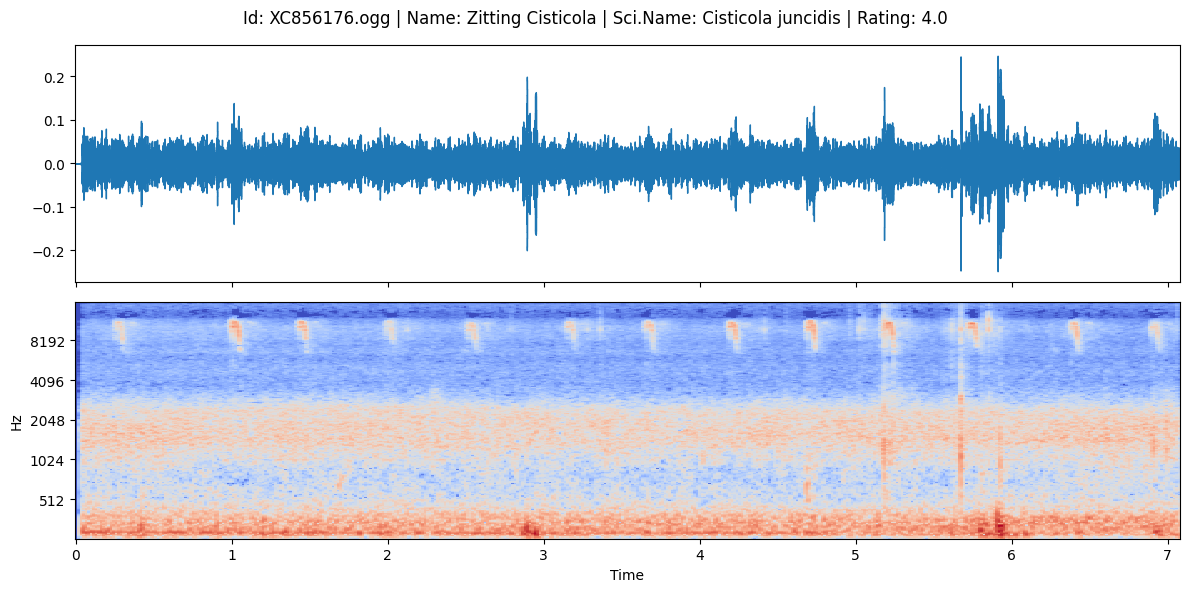

In [12]:
row = df.iloc[24456]

# Display audio
display_audio(row)

# Audio:


# Visualization:


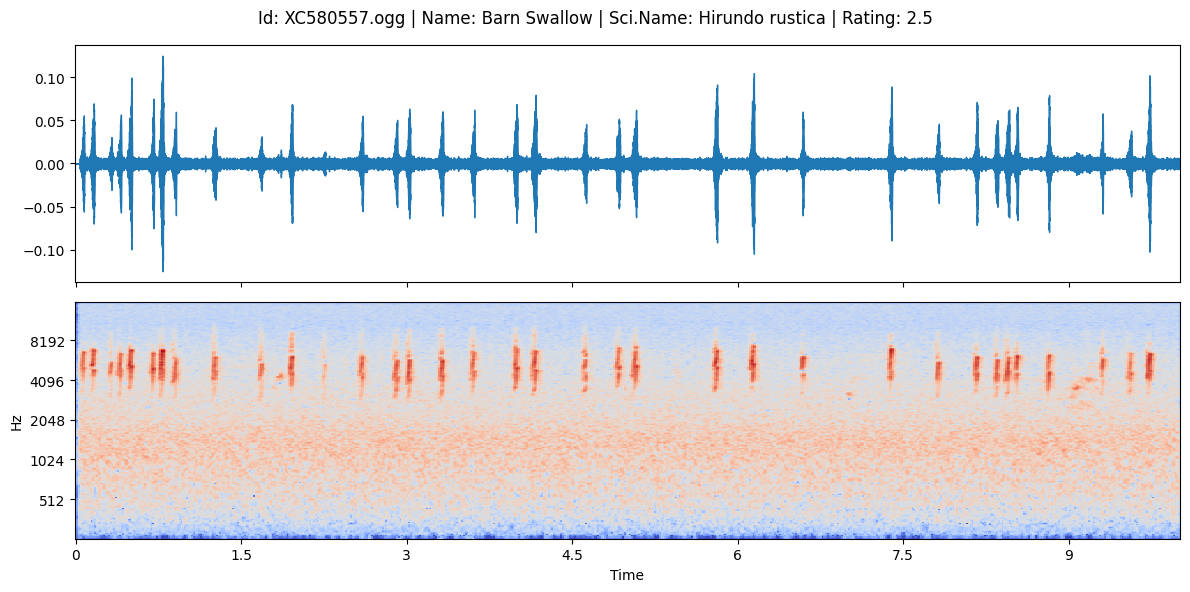

In [13]:
row = df.iloc[1000]

# Display audio
display_audio(row)

# Pre-process audio 

In [14]:
AUDIO_DIR = "/kaggle/input/birdclef-2024/train_audio"
OUT_DIR   = "/kaggle/working/spec_train"

In [15]:
###########TAKEN FROM NOTEBOOK: https://www.kaggle.com/code/awsaf49/birdclef24-kerascv-starter-train
def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=CFG.mels,
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    else:
        spec = spec * 0.0
    return spec.astype(np.float32)

#########################OTHER HELPER FUNCTIONS##############################
def load_and_fix_length(audio_path, target_len=CFG.audio_len, sr=CFG.sample_rate):
    audio, _ = librosa.load(audio_path, sr=sr)
    orig_audio_len = len(audio)
    if orig_audio_len > target_len:
        audio = audio[:target_len]
    elif orig_audio_len < target_len:
        pad = target_len - orig_audio_len
        audio = np.pad(audio, (0, pad), mode="constant")
    return audio

def pad_time_to_multiple_of_16(spec, patch_size=16):
    # spec shape: (n_mels, n_frames)
    n_mels, n_frames = spec.shape 

    target_frames = int(np.ceil(n_frames / patch_size) * patch_size)

    if n_frames == target_frames:
        return spec

    pad_width = target_frames - n_frames
    spec_padded = np.pad(
        spec,
        ((0, 0), (0, pad_width)), 
        mode="constant",
        constant_values=0.0)
    return spec_padded

In [16]:
os.makedirs(OUT_DIR, exist_ok=True)
species_list = sorted(d for d in os.listdir(AUDIO_DIR))
smaller_species_list_1 = species_list[:len(species_list)//4]
smaller_species_list_2 = species_list[len(species_list)//4: (2*len(species_list))//4]
smaller_species_list_3 = species_list[(2*len(species_list))//4: (3*len(species_list))//4]
smaller_species_list_4 = species_list[(3*len(species_list))//4: ]
print(len(smaller_species_list_1), len(smaller_species_list_2), len(smaller_species_list_3), len(smaller_species_list_4))

45 46 45 46


In [17]:
for species in tqdm(species_list):
    species_audio_dir = os.path.join(AUDIO_DIR, species)
    species_out_dir = os.path.join(OUT_DIR, species)
    os.makedirs(species_out_dir, exist_ok=True)

    audio_files = []
    for file in os.listdir(species_audio_dir):
        if file.lower().endswith(".ogg"):
            audio_files.append(file)

    print(f"Processing species: {species} ({len(audio_files)} files)")
    for fname in audio_files:
        in_path  = os.path.join(species_audio_dir, fname)
        base = fname[:-4]
        out_path = os.path.join(species_out_dir, base + ".npy")
        audio = load_and_fix_length(in_path)
        spec = get_spectrogram(audio)
        spec = pad_time_to_multiple_of_16(spec, patch_size=16)
        spec = spec.astype(np.float16)
        np.save(out_path, spec)

  0%|          | 0/182 [00:00<?, ?it/s]

Processing species: asbfly (105 files)


  1%|          | 1/182 [00:06<20:51,  6.91s/it]

Processing species: ashdro1 (109 files)


  1%|          | 2/182 [00:14<21:17,  7.10s/it]

Processing species: ashpri1 (96 files)


  2%|▏         | 3/182 [00:19<19:17,  6.47s/it]

Processing species: ashwoo2 (45 files)


  2%|▏         | 4/182 [00:22<14:39,  4.94s/it]

Processing species: asikoe2 (275 files)


  3%|▎         | 6/182 [00:39<18:04,  6.16s/it]

Processing species: asiope1 (5 files)
Processing species: aspfly1 (26 files)


  4%|▍         | 7/182 [00:40<13:15,  4.55s/it]

Processing species: aspswi1 (26 files)


  4%|▍         | 8/182 [00:42<10:10,  3.51s/it]

Processing species: barfly1 (20 files)


  5%|▍         | 9/182 [00:44<09:35,  3.33s/it]

Processing species: barswa (500 files)


  5%|▌         | 10/182 [01:17<35:03, 12.23s/it]

Processing species: bcnher (500 files)


  6%|▌         | 11/182 [01:48<51:16, 17.99s/it]

Processing species: bkcbul1 (24 files)


  7%|▋         | 12/182 [01:49<36:41, 12.95s/it]

Processing species: bkrfla1 (29 files)


  7%|▋         | 13/182 [01:50<26:34,  9.43s/it]

Processing species: bkskit1 (268 files)


  8%|▊         | 14/182 [02:08<32:59, 11.78s/it]

Processing species: bkwsti (500 files)


  8%|▊         | 15/182 [02:43<52:53, 19.00s/it]

Processing species: bladro1 (125 files)


  9%|▉         | 16/182 [02:52<44:21, 16.03s/it]

Processing species: blaeag1 (6 files)


  9%|▉         | 17/182 [02:53<31:03, 11.29s/it]

Processing species: blakit1 (231 files)


 10%|▉         | 18/182 [03:08<33:56, 12.42s/it]

Processing species: blhori1 (141 files)


 10%|█         | 19/182 [03:16<30:20, 11.17s/it]

Processing species: blnmon1 (173 files)


 11%|█         | 20/182 [03:26<29:19, 10.86s/it]

Processing species: blrwar1 (500 files)


 12%|█▏        | 21/182 [05:03<1:38:01, 36.53s/it]

Processing species: bncwoo3 (7 files)


 12%|█▏        | 22/182 [05:03<1:08:29, 25.69s/it]

Processing species: brakit1 (44 files)


 13%|█▎        | 23/182 [05:05<49:25, 18.65s/it]  

Processing species: brasta1 (13 files)


 13%|█▎        | 24/182 [05:06<34:54, 13.26s/it]

Processing species: brcful1 (86 files)


 14%|█▎        | 25/182 [05:12<28:43, 10.98s/it]

Processing species: brfowl1 (17 files)


 14%|█▍        | 26/182 [05:13<20:58,  8.06s/it]

Processing species: brnhao1 (122 files)


 15%|█▍        | 27/182 [05:21<20:42,  8.01s/it]

Processing species: brnshr (150 files)


 15%|█▌        | 28/182 [05:31<21:58,  8.56s/it]

Processing species: brodro1 (114 files)


 16%|█▌        | 29/182 [05:38<21:20,  8.37s/it]

Processing species: brwjac1 (20 files)


 16%|█▋        | 30/182 [05:39<15:30,  6.12s/it]

Processing species: brwowl1 (79 files)


 17%|█▋        | 31/182 [05:45<15:18,  6.08s/it]

Processing species: btbeat1 (57 files)


 18%|█▊        | 32/182 [05:49<13:06,  5.24s/it]

Processing species: bwfshr1 (31 files)


 18%|█▊        | 33/182 [05:50<10:27,  4.21s/it]

Processing species: categr (210 files)


 19%|█▊        | 34/182 [06:05<18:16,  7.41s/it]

Processing species: chbeat1 (22 files)


 19%|█▉        | 35/182 [06:06<13:24,  5.48s/it]

Processing species: cohcuc1 (76 files)


 20%|█▉        | 36/182 [06:12<13:09,  5.41s/it]

Processing species: comfla1 (32 files)


 20%|██        | 37/182 [06:13<10:18,  4.26s/it]

Processing species: comgre (500 files)


 21%|██        | 38/182 [06:42<27:50, 11.60s/it]

Processing species: comior1 (219 files)


 21%|██▏       | 39/182 [06:56<29:24, 12.34s/it]

Processing species: comkin1 (500 files)


 22%|██▏       | 40/182 [07:23<39:35, 16.73s/it]

Processing species: commoo3 (500 files)


 23%|██▎       | 41/182 [07:49<45:42, 19.45s/it]

Processing species: commyn (237 files)


 23%|██▎       | 42/182 [08:20<53:43, 23.03s/it]

Processing species: compea (70 files)


 24%|██▎       | 43/182 [08:23<39:34, 17.08s/it]

Processing species: comros (500 files)


 24%|██▍       | 44/182 [09:00<53:05, 23.09s/it]

Processing species: comsan (500 files)


 25%|██▍       | 45/182 [09:25<53:57, 23.63s/it]

Processing species: comtai1 (302 files)


 25%|██▌       | 46/182 [09:42<49:04, 21.65s/it]

Processing species: copbar1 (124 files)


 26%|██▌       | 47/182 [09:49<38:56, 17.31s/it]

Processing species: crbsun2 (24 files)


 26%|██▋       | 48/182 [09:51<27:56, 12.51s/it]

Processing species: cregos1 (40 files)


 27%|██▋       | 49/182 [09:54<21:41,  9.78s/it]

Processing species: crfbar1 (13 files)


 27%|██▋       | 50/182 [09:55<15:32,  7.06s/it]

Processing species: crseag1 (153 files)


 28%|██▊       | 51/182 [10:04<16:50,  7.72s/it]

Processing species: dafbab1 (22 files)


 29%|██▊       | 52/182 [10:05<12:22,  5.71s/it]

Processing species: darter2 (7 files)


 29%|██▉       | 53/182 [10:05<08:46,  4.08s/it]

Processing species: eaywag1 (500 files)


 30%|██▉       | 54/182 [10:33<23:26, 10.99s/it]

Processing species: emedov2 (53 files)


 30%|███       | 55/182 [10:36<18:31,  8.75s/it]

Processing species: eucdov (500 files)


 31%|███       | 56/182 [11:09<33:29, 15.95s/it]

Processing species: eurbla2 (24 files)


 31%|███▏      | 57/182 [11:10<24:01, 11.54s/it]

Processing species: eurcoo (500 files)


 32%|███▏      | 58/182 [11:38<34:01, 16.47s/it]

Processing species: forwag1 (44 files)


 32%|███▏      | 59/182 [11:41<25:32, 12.46s/it]

Processing species: gargan (163 files)


 33%|███▎      | 60/182 [11:49<22:32, 11.09s/it]

Processing species: gloibi (107 files)


 34%|███▎      | 61/182 [11:54<18:38,  9.25s/it]

Processing species: goflea1 (46 files)


 34%|███▍      | 62/182 [11:58<15:03,  7.53s/it]

Processing species: graher1 (500 files)


 35%|███▍      | 63/182 [12:29<29:04, 14.66s/it]

Processing species: grbeat1 (67 files)


 35%|███▌      | 64/182 [12:32<22:10, 11.27s/it]

Processing species: grecou1 (163 files)


 36%|███▌      | 65/182 [12:42<21:13, 10.88s/it]

Processing species: greegr (276 files)


 36%|███▋      | 66/182 [12:55<21:59, 11.38s/it]

Processing species: grefla1 (58 files)


 37%|███▋      | 67/182 [12:58<17:03,  8.90s/it]

Processing species: grehor1 (37 files)


 37%|███▋      | 68/182 [13:00<13:03,  6.87s/it]

Processing species: grejun2 (51 files)


 38%|███▊      | 69/182 [13:03<10:59,  5.84s/it]

Processing species: grenig1 (41 files)


 38%|███▊      | 70/182 [13:06<08:55,  4.78s/it]

Processing species: grewar3 (500 files)


 39%|███▉      | 71/182 [13:48<29:46, 16.10s/it]

Processing species: grnsan (500 files)


 40%|███▉      | 72/182 [14:13<34:20, 18.73s/it]

Processing species: grnwar1 (142 files)


 40%|████      | 73/182 [14:22<28:52, 15.90s/it]

Processing species: grtdro1 (278 files)


 41%|████      | 74/182 [14:41<29:54, 16.62s/it]

Processing species: gryfra (56 files)


 41%|████      | 75/182 [14:43<22:05, 12.39s/it]

Processing species: grynig2 (20 files)


 42%|████▏     | 76/182 [14:44<15:49,  8.96s/it]

Processing species: grywag (500 files)


 42%|████▏     | 77/182 [15:13<26:07, 14.93s/it]

Processing species: gybpri1 (115 files)


 43%|████▎     | 78/182 [15:20<21:39, 12.49s/it]

Processing species: gyhcaf1 (217 files)


 43%|████▎     | 79/182 [15:34<22:31, 13.12s/it]

Processing species: heswoo1 (22 files)


 44%|████▍     | 80/182 [15:36<16:16,  9.57s/it]

Processing species: hoopoe (500 files)


 45%|████▍     | 81/182 [16:16<31:32, 18.74s/it]

Processing species: houcro1 (139 files)


 45%|████▌     | 82/182 [16:24<26:03, 15.63s/it]

Processing species: houspa (500 files)


 46%|████▌     | 83/182 [17:17<44:07, 26.75s/it]

Processing species: inbrob1 (59 files)


 46%|████▌     | 84/182 [17:22<33:02, 20.23s/it]

Processing species: indpit1 (61 files)


 47%|████▋     | 85/182 [17:26<24:49, 15.36s/it]

Processing species: indrob1 (44 files)


 47%|████▋     | 86/182 [17:29<18:28, 11.55s/it]

Processing species: indrol2 (35 files)


 48%|████▊     | 87/182 [17:31<13:44,  8.68s/it]

Processing species: indtit1 (12 files)


 48%|████▊     | 88/182 [17:31<09:51,  6.29s/it]

Processing species: ingori1 (40 files)


 49%|████▉     | 89/182 [17:35<08:21,  5.39s/it]

Processing species: inpher1 (13 files)


 49%|████▉     | 90/182 [17:35<05:59,  3.91s/it]

Processing species: insbab1 (63 files)


 50%|█████     | 91/182 [17:39<06:01,  3.97s/it]

Processing species: insowl1 (36 files)


 51%|█████     | 93/182 [17:42<03:40,  2.48s/it]

Processing species: integr (5 files)
Processing species: isbduc1 (16 files)


 52%|█████▏    | 94/182 [17:42<02:52,  1.96s/it]

Processing species: jerbus2 (19 files)


 52%|█████▏    | 95/182 [17:43<02:29,  1.72s/it]

Processing species: junbab2 (79 files)


 53%|█████▎    | 96/182 [17:49<04:04,  2.84s/it]

Processing species: junmyn1 (15 files)


 53%|█████▎    | 97/182 [17:50<03:10,  2.24s/it]

Processing species: junowl1 (49 files)


 54%|█████▍    | 98/182 [17:53<03:33,  2.54s/it]

Processing species: kenplo1 (271 files)


 54%|█████▍    | 99/182 [18:07<08:10,  5.91s/it]

Processing species: kerlau2 (14 files)


 55%|█████▍    | 100/182 [18:08<05:58,  4.38s/it]

Processing species: labcro1 (235 files)


 55%|█████▌    | 101/182 [18:23<10:12,  7.56s/it]

Processing species: laudov1 (113 files)


 56%|█████▌    | 102/182 [18:30<09:55,  7.45s/it]

Processing species: lblwar1 (90 files)


 57%|█████▋    | 103/182 [18:35<08:59,  6.83s/it]

Processing species: lesyel1 (22 files)


 57%|█████▋    | 104/182 [18:37<06:49,  5.24s/it]

Processing species: lewduc1 (33 files)


 58%|█████▊    | 105/182 [18:39<05:25,  4.22s/it]

Processing species: lirplo (500 files)


 58%|█████▊    | 106/182 [19:07<14:44, 11.64s/it]

Processing species: litegr (405 files)


 59%|█████▉    | 107/182 [19:29<18:21, 14.68s/it]

Processing species: litgre1 (500 files)


 59%|█████▉    | 108/182 [19:54<21:56, 17.79s/it]

Processing species: litspi1 (123 files)


 60%|█████▉    | 109/182 [20:01<17:42, 14.56s/it]

Processing species: litswi1 (77 files)


 60%|██████    | 110/182 [20:07<14:27, 12.04s/it]

Processing species: lobsun2 (20 files)


 61%|██████    | 111/182 [20:09<10:25,  8.81s/it]

Processing species: maghor2 (30 files)


 62%|██████▏   | 112/182 [20:11<07:53,  6.76s/it]

Processing species: malpar1 (20 files)


 62%|██████▏   | 113/182 [20:12<05:50,  5.08s/it]

Processing species: maltro1 (17 files)


 63%|██████▎   | 114/182 [20:13<04:18,  3.80s/it]

Processing species: malwoo1 (10 files)


 63%|██████▎   | 115/182 [20:13<03:09,  2.82s/it]

Processing species: marsan (92 files)


 64%|██████▎   | 116/182 [20:18<03:36,  3.28s/it]

Processing species: mawthr1 (46 files)


 64%|██████▍   | 117/182 [20:21<03:26,  3.18s/it]

Processing species: moipig1 (27 files)


 65%|██████▍   | 118/182 [20:22<02:51,  2.67s/it]

Processing species: nilfly2 (8 files)


 65%|██████▌   | 119/182 [20:22<02:06,  2.01s/it]

Processing species: niwpig1 (5 files)


 66%|██████▌   | 120/182 [20:23<01:31,  1.47s/it]

Processing species: nutman (115 files)


 66%|██████▋   | 121/182 [20:29<03:02,  3.00s/it]

Processing species: orihob2 (41 files)


 67%|██████▋   | 122/182 [20:32<02:47,  2.79s/it]

Processing species: oripip1 (71 files)


 68%|██████▊   | 123/182 [20:35<02:58,  3.02s/it]

Processing species: pabflo1 (47 files)


 68%|██████▊   | 124/182 [20:38<02:51,  2.95s/it]

Processing species: paisto1 (7 files)


 69%|██████▊   | 125/182 [20:38<02:05,  2.20s/it]

Processing species: piebus1 (89 files)


 69%|██████▉   | 126/182 [20:44<03:02,  3.25s/it]

Processing species: piekin1 (137 files)


 70%|██████▉   | 127/182 [20:51<04:03,  4.43s/it]

Processing species: placuc3 (38 files)


 70%|███████   | 128/182 [20:54<03:26,  3.82s/it]

Processing species: plaflo1 (20 files)


 71%|███████   | 129/182 [20:55<02:36,  2.95s/it]

Processing species: plapri1 (155 files)


 71%|███████▏  | 130/182 [21:04<04:09,  4.80s/it]

Processing species: plhpar1 (28 files)


 72%|███████▏  | 131/182 [21:05<03:16,  3.85s/it]

Processing species: pomgrp2 (9 files)


 73%|███████▎  | 132/182 [21:06<02:20,  2.81s/it]

Processing species: purher1 (274 files)


 73%|███████▎  | 133/182 [21:19<04:59,  6.10s/it]

Processing species: pursun3 (56 files)


 74%|███████▎  | 134/182 [21:23<04:13,  5.27s/it]

Processing species: pursun4 (125 files)


 74%|███████▍  | 135/182 [21:30<04:39,  5.95s/it]

Processing species: purswa3 (39 files)


 75%|███████▍  | 136/182 [21:32<03:40,  4.79s/it]

Processing species: putbab1 (224 files)


 75%|███████▌  | 137/182 [21:48<06:06,  8.15s/it]

Processing species: redspu1 (16 files)


 76%|███████▌  | 138/182 [21:49<04:20,  5.93s/it]

Processing species: rerswa1 (198 files)


 76%|███████▋  | 139/182 [22:01<05:33,  7.75s/it]

Processing species: revbul (101 files)


 77%|███████▋  | 140/182 [22:08<05:11,  7.41s/it]

Processing species: rewbul (189 files)


 77%|███████▋  | 141/182 [22:22<06:31,  9.55s/it]

Processing species: rewlap1 (135 files)


 78%|███████▊  | 142/182 [22:30<05:59,  9.00s/it]

Processing species: rocpig (201 files)


 79%|███████▊  | 143/182 [22:43<06:35, 10.15s/it]

Processing species: rorpar (420 files)


 79%|███████▉  | 144/182 [23:08<09:20, 14.74s/it]

Processing species: rossta2 (60 files)


 80%|███████▉  | 145/182 [23:13<07:08, 11.59s/it]

Processing species: rufbab3 (17 files)


 80%|████████  | 146/182 [23:14<05:02,  8.41s/it]

Processing species: ruftre2 (127 files)


 81%|████████  | 147/182 [23:21<04:42,  8.07s/it]

Processing species: rufwoo2 (49 files)


 81%|████████▏ | 148/182 [23:23<03:36,  6.37s/it]

Processing species: rutfly6 (8 files)


 82%|████████▏ | 149/182 [23:24<02:31,  4.60s/it]

Processing species: sbeowl1 (25 files)


 82%|████████▏ | 150/182 [23:25<02:00,  3.75s/it]

Processing species: scamin3 (12 files)


 83%|████████▎ | 151/182 [23:26<01:26,  2.79s/it]

Processing species: shikra1 (96 files)


 84%|████████▎ | 152/182 [23:32<01:49,  3.64s/it]

Processing species: smamin1 (20 files)


 84%|████████▍ | 153/182 [23:33<01:21,  2.82s/it]

Processing species: sohmyn1 (42 files)


 85%|████████▍ | 154/182 [23:36<01:22,  2.95s/it]

Processing species: spepic1 (45 files)


 85%|████████▌ | 155/182 [23:38<01:17,  2.86s/it]

Processing species: spodov (155 files)


 86%|████████▌ | 156/182 [23:48<02:08,  4.93s/it]

Processing species: spoowl1 (35 files)


 86%|████████▋ | 157/182 [23:50<01:39,  4.00s/it]

Processing species: sqtbul1 (24 files)


 87%|████████▋ | 158/182 [23:51<01:17,  3.23s/it]

Processing species: stbkin1 (122 files)


 87%|████████▋ | 159/182 [23:59<01:43,  4.49s/it]

Processing species: sttwoo1 (20 files)


 88%|████████▊ | 160/182 [24:00<01:16,  3.50s/it]

Processing species: thbwar1 (102 files)


 88%|████████▊ | 161/182 [24:11<01:58,  5.66s/it]

Processing species: tibfly3 (104 files)


 89%|████████▉ | 162/182 [24:17<01:58,  5.94s/it]

Processing species: tilwar1 (21 files)


 90%|████████▉ | 163/182 [24:19<01:26,  4.55s/it]

Processing species: vefnut1 (41 files)


 90%|█████████ | 164/182 [24:21<01:08,  3.82s/it]

Processing species: vehpar1 (36 files)


 91%|█████████ | 165/182 [24:22<00:54,  3.18s/it]

Processing species: wbbfly1 (7 files)


 91%|█████████ | 166/182 [24:23<00:37,  2.34s/it]

Processing species: wemhar1 (273 files)


 92%|█████████▏| 167/182 [24:40<01:40,  6.67s/it]

Processing species: whbbul2 (52 files)


 92%|█████████▏| 168/182 [24:42<01:16,  5.45s/it]

Processing species: whbsho3 (22 files)


 93%|█████████▎| 169/182 [24:45<01:01,  4.77s/it]

Processing species: whbtre1 (21 files)


 93%|█████████▎| 170/182 [24:47<00:44,  3.74s/it]

Processing species: whbwag1 (34 files)


 94%|█████████▍| 171/182 [24:49<00:36,  3.29s/it]

Processing species: whbwat1 (167 files)


 95%|█████████▍| 172/182 [25:01<00:59,  5.92s/it]

Processing species: whbwoo2 (75 files)


 95%|█████████▌| 173/182 [25:06<00:49,  5.53s/it]

Processing species: whcbar1 (56 files)


 96%|█████████▌| 174/182 [25:08<00:37,  4.71s/it]

Processing species: whiter2 (226 files)


 96%|█████████▌| 175/182 [25:23<00:54,  7.75s/it]

Processing species: whrmun (63 files)


 97%|█████████▋| 176/182 [25:27<00:39,  6.55s/it]

Processing species: whtkin2 (185 files)


 97%|█████████▋| 177/182 [25:37<00:38,  7.62s/it]

Processing species: woosan (500 files)


 98%|█████████▊| 178/182 [26:05<00:55, 13.81s/it]

Processing species: wynlau1 (6 files)


 98%|█████████▊| 179/182 [26:06<00:29,  9.81s/it]

Processing species: yebbab1 (28 files)


 99%|█████████▉| 180/182 [26:07<00:14,  7.32s/it]

Processing species: yebbul3 (30 files)


 99%|█████████▉| 181/182 [26:09<00:05,  5.66s/it]

Processing species: zitcis1 (500 files)


100%|██████████| 182/182 [26:38<00:00,  8.78s/it]


Spec shape: (128, 512)


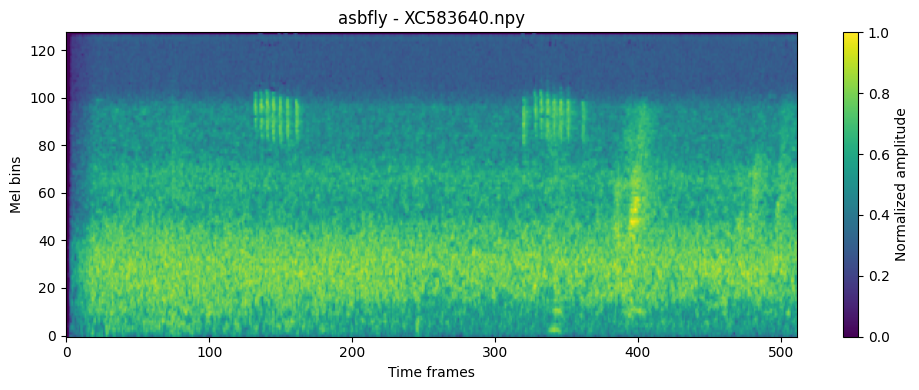

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Example path – adjust species + filename
species = "asbfly"
fname = "XC583640.npy"   # whatever file you saved
SPEC_DIR = "/kaggle/working/spec_train"  # or your OUT_DIR

spec_path = '/kaggle/working/spec_train/asbfly/XC687954.npy'

# 1. Load the spectrogram
spec = np.load(spec_path)   # shape: (n_mels, n_frames)

print("Spec shape:", spec.shape)

# 2. Plot it
plt.figure(figsize=(10, 4))
plt.imshow(spec, aspect="auto", origin="lower")
plt.colorbar(label="Normalized amplitude")
plt.title(f"{species} - {fname}")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.tight_layout()
plt.show()

In [19]:
# # Paths
# import shutil
# zip_path_specs = '/kaggle/working/spec_train.zip'
# # Create zip
# shutil.make_archive(base_name=zip_path_specs.replace('.zip', ''), format='zip', root_dir=SPEC_DIR)
# print(f"Zipped to: {zip_path_specs}")

# Data Sets

In [20]:
# def seed_everything(seed=42):
#     """
#     Set random seeds for reproducibility in deep learning projects.
    
#     Args:
#         seed (int): Random seed value (default: 42)
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if using multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     os.environ['PYTHONHASHSEED'] = str(seed)

# seed_everything()

https://stats.stackexchange.com/questions/502714/the-ratio-of-validation-set-and-test-set-should-be-equal

https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

https://www.v7labs.com/blog/train-validation-test-set

# Data Loader

In [21]:
# test_frac = 0.2
# val_frac = 0.1
# val_frac_within_trainval = val_frac / (1 - test_frac)
# print(f"The original dataset has {len(df)} samples.")

In [22]:
# train_idx, shared_idx = train_test_split(
#     df.index, 
#     test_size = 0.3,
#     stratify=df["primary_label"],
#     random_state = 42
# )

# val_idx, test_idx = train_test_split(
#     shared_idx,
#     test_size = 0.5,
#     stratify=df.loc[temp_idx, "primary_label"],
#     random_state = 42    
# )

# train_df = df.loc[train_idx].reset_index(drop=True)
# val_df   = df.loc[val_idx].reset_index(drop=True)
# test_df  = df.loc[test_idx].reset_index(drop=True)

# print("Train size:", len(train_df))
# print("Val size:  ", len(val_df))
# print("Test size: ", len(test_df))

# print("\nTrain label counts:")
# print(train_df["primary_label"].value_counts().head())

# print("\nVal label counts:")
# print(val_df["primary_label"].value_counts().head())

# print("\nTest label counts:")
# print(test_df["primary_label"].value_counts().head())